In [1]:
import ee
import geemap
# 不再需要 import sys, import os (除非其他地方用到)
# 也不再需要任何 sys.path.append(...)

# 初始化GEE
ee.Initialize(project='geemap-441216') # 替换为您的项目ID

# Python会自动在当前文件夹下寻找模块，所以可以直接导入！
try:
    import z_flood_robust
    from z_flood_robust import zscore # 甚至可以这样导入
    zscore.calc_basemad # 尝试访问
    print("本地自定义模块 z_flood_robust 已成功导入！")
except ImportError as e:
    print(f"导入模块失败: {e}")
    print("请确保'z_flood_robust'文件夹与您的Jupyter笔记本在同一个目录下。")

本地自定义模块 z_flood_robust 已成功导入！


# 1.导入依赖-数据管理模块

In [2]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle #用于在图表中添加形状(例如矩形)
import re #正则表达式模块
from z_flood_robust import calc_basemedian, calc_basemad, calc_median_anomaly, calc_robust_zscore, calc_basemean,calc_basestd,calc_zscore
from z_flood_robust import mapFloods,floodPalette

from ipywidgets import Label #用于创建交互式控件



# 2.定义交互式地图以选择感兴趣区域-界面与交互模块

In [7]:
#解析用户点击地图时生成的坐标字符串，提取经纬度并返回
def parseClickedCoordinates(label):
  #利用正则表达式，从label.value提取出坐标：一个可能带有负号的浮点数 这里为【经度，纬度】
  #正则表达式： r'(?:-)?[0-9]+.[0-9]+'
  #r'表示原始字符，(?:-)是非捕获组，?:表示负号是可选的，[0-9]+表示匹配一个数字，+表示可以出现一次或多次，.匹配小数点，最后再次匹配一个或多个数字
  coords = [float(c) for c in re.findall(r'(?:-)?[0-9]+.[0-9]+', label.value)]
  coords.reverse() #反转为【纬度，经度】，符合GEE坐标格式
  return coords

#创建一个Lable，用于显示用户点击的目标
l = Label()
display(1)
#处理用户与地图的交互事件，当用户点击地图时，将点击的坐标存储到Label控件中
def handle_interaction(**kwargs):
  #kwargs包含交互事件的参数 kwargs.get('type'):获取事件类型为鼠标点击 kwargs.get('coordinates')：获取点击的坐标，转换为字符串并存储到Label控件中
  if kwargs.get('type') == 'click':
    l.value = str(kwargs.get('coordinates'))

print('请点击地图以选择你要监测的区域')
#创建交互式地图
Map = geemap.Map()
Map.on_interaction(handle_interaction)
Map

1

请点击地图以选择你要监测的区域


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', transp…

# 3.定义几何范围并展示-界面与交互模块

## 1.确定研究区域

In [8]:
lon,lat = parseClickedCoordinates(l)
w,h = 2,2 #矩形宽度与高度（单位：度）

geometry = ee.Geometry.Polygon(
    [[[lon-w,lat-h],
     [lon-w,lat+h],
     [lon+w,lat+h],
     [lon+w,lat-h]]]
)

#将几何范围添加到地图
Map.addLayer(
    geometry,
    {'color':'red','fillColor':'00000000'},
    'AOI'
)
Map

Map(bottom=399571.0, center=[39.39200267802514, -0.4658574330748101], controls=(WidgetControl(options=['positi…

In [9]:
#USE MAP RECTANGLE 选择区域
#获取感兴趣区域（用于论文绘图)
roi_choose1 = Map.user_roi

if roi_choose1 is not None:
  #获取ROI类型
  roi_type = roi_choose1.type().getInfo()
  print(f"ROI 类型：{roi_type}")

  #如果是Polygon，获取坐标
  if roi_type == 'Polygon':
    coords = roi_choose1.coordinates().getInfo()
    print(f"ROI 坐标：{coords}")

ROI 类型：Polygon
ROI 坐标：[[[-0.424622, 39.348315], [-0.424622, 39.456554], [-0.339135, 39.456554], [-0.339135, 39.348315], [-0.424622, 39.348315]]]


## 2.显示影像数量图

In [ ]:
# ==============================================================================
# 3.1: (再次修正版) 生成并可视化Sentinel-1影像覆盖密度图
# ==============================================================================
from datetime import datetime

print("\n--- [再次修正版] 开始生成研究区Sentinel-1影像覆盖密度图 ---")

# --- 1. 定义时间范围和影像集合 ---
end_date_ee = ee.Date('2024-10-31') 
start_date_ee = end_date_ee.advance(-2, 'year')

print(f"时间范围: {start_date_ee.format('YYYY-MM-dd').getInfo()} 到 {end_date_ee.format('YYYY-MM-dd').getInfo()}")

s1_collection_for_count = ee.ImageCollection("COPERNICUS/S1_GRD") \
    .filterBounds(geometry) \
    .filterDate(start_date_ee, end_date_ee) \
    .filter(ee.Filter.equals("instrumentMode", "IW"))

collection_size = s1_collection_for_count.size().getInfo()
print(f"在指定时间范围和区域内，共找到 {collection_size} 景Sentinel-1影像。")


# --- 只有在找到影像时，才执行后续的计算和可视化 ---
if collection_size > 0:

    # --- 2. 计算每个像素的影像覆盖数量 ---
    # 这一步生成的image_count是多波段的
    image_count = s1_collection_for_count.count()

    # --- 3. 动态确定可视化的最大/最小值 ---
    # 我们在VV波段上计算统计值
    min_max_values = image_count.select('VV').reduceRegion(
        reducer=ee.Reducer.minMax(),
        geometry=geometry,
        scale=100,
        maxPixels=1e9
    ).getInfo()

    # .get('VV_min') / .get('VV_max') 因为reduceRegion会自动重命名波段
    if min_max_values and 'VV_max' in min_max_values:
        min_count = int(min_max_values.get('VV_min', 0))
        max_count = int(min_max_values.get('VV_max', 1))
    else:
        min_count, max_count = 0, 100
        print("警告：未能动态计算范围，使用默认值 0-100。")
    
    if min_count == max_count:
        max_count = min_count + 1

    print(f"影像覆盖数量范围: 最小={min_count}, 最大={max_count}")

    # --- 4. 定义可视化参数 ---
    density_palette = [
        '#FFFFE0', '#FBC699', '#E88482', '#B95290', '#6A2A7A', '#2D0B59'
    ]
    vis_params_count = {
        'min': min_count,
        'max': max_count,
        'palette': density_palette,
        'opacity':0.7
    }

    # --- 5. 在地图上显示结果 ---
    CountMap = geemap.Map()
    
    # (核心修正) 在添加到图层前，使用 .select('VV') 来选择单个波段
    CountMap.addLayer(
        image_count.select('VV').clip(geometry), 
        vis_params_count, 
        'Sentinel-1 Image Count (VV)' # 图层名可以更具体
    )
    
    CountMap.addLayer(
        geometry,
        {'color':'black','fillColor':'00000000'},
        'AOI Outline'
    )
    CountMap.add_colorbar(vis_params_count, label="Image Count")
    CountMap.centerObject(geometry, 10)
    display(CountMap)

else:
    print("\n错误：在指定的研究区和时间范围内未找到任何Sentinel-1影像。")
    print("请尝试：\n1. 检查您选择的AOI是否在陆地区域。\n2. 扩大时间范围或更换研究区。")

In [ ]:

# ==============================================================================
# 3.2: (新增) 导出影像覆盖密度图到 Google Drive
# ==============================================================================

# 只有在影像集合不为空时，才执行导出操作
if 'image_count' in globals():
    print("\n--- [新增步骤] 正在提交影像覆盖密度图的导出任务 ---")

    # 定义导出的文件名和文件夹
    export_folder = 'image_count'
    export_filename = 'Valencia_s1_Count'

    # 准备导出任务
    task = ee.batch.Export.image.toDrive(
        image=image_count.select('VV').clip(geometry), # 确保选择单波段并裁剪
        description='Valencia_Export_S1_Image_Count', # GEE Tasks面板中显示的任务名
        folder=export_folder,      # 在Google Drive中要保存到的文件夹名
        fileNamePrefix=export_filename, # 最终的文件名
        region=geometry,
        scale=100,  # 对于区域概览图，不需要10米全分辨率，100米足够清晰且文件小
        fileFormat='GeoTIFF',
        maxPixels=1e13
    )

    # 启动任务
    task.start()

    print(f"成功提交任务！")
    print(f"请前往 GEE Code Editor 的 'Tasks' 标签页, 找到名为 'Export_S1_Image_Count' 的任务并点击 'RUN'。")
    print(f"任务完成后，文件 '{export_filename}.tif' 将会出现在您Google Drive的 '{export_folder}' 文件夹中。")

else:
    print("\n'image_count' 影像不存在，跳过导出步骤。")

# 4.过滤Sentinel-1数据-数据管理模块

# 4.1 过滤影像计算数量（以下是西班牙巴伦西亚区域）

In [10]:
targdate = '2024-10-31'   # 目标日期 (需要根据实际数据可用性验证或微调)
basestart = '2023-11-20'  # 基线开始日期
baseend = '2024-09-10'   # 基线结束日期

# !!! (可选) 替换硬编码的 aoi2 !!!
# 如果你决定使用固定的 valencia_aoi，在这里替换：
#aoi3 = ee.Geometry.Rectangle([-0.55, 39.35, -0.30, 39.50]) # 新的巴伦西亚AOI
# !!! 更好的做法是完全不用 aoi2，下面 filterBounds 直接用 analysis_aoi !!!

filters = [
    ee.Filter.listContains("transmitterReceiverPolarisation", "VV"),
    ee.Filter.listContains("transmitterReceiverPolarisation", "VH"), # 如果需要VH也取消注释
    ee.Filter.equals("instrumentMode", "IW"),
    # !!! 重要：检查轨道方向 !!!
    # 需要确认 targdate 前后过境巴伦西亚的 S1 影像是升轨还是降轨
    # 可能需要改为 'DESCENDING'，或不加这个过滤器以获取所有轨道
    ee.Filter.equals("orbitProperties_pass", "ASCENDING"), # <--- 可能需要修改或移除!
    # 时间过滤器现在是动态的，覆盖基线期和目标期，无需修改
    ee.Filter.date('2022-08-21', ee.Date(targdate).advance(1, 'day'))
]

# 加载S1数据并计算Z分数
s1 = ee.ImageCollection("COPERNICUS/S1_GRD") \
    .filter(filters) \
    .filterBounds(roi_choose1) # !!! 使用统一的 analysis_aoi !!!



# 检查是否有影像满足条件
s1_size = s1.size().getInfo()
print(f"找到满足条件的 Sentinel-1 影像数量: {s1_size}")
if s1_size == 0:
    print("警告：未找到满足条件的影像，请检查时间范围、AOI 或轨道方向过滤器！")
print(s1.aggregate_array('system:time_start').map(lambda t: ee.Date(t).format()).getInfo())

# Z 分数计算 (轨道方向参数需要与上面 filter 保持一致)
# orbit_direction = "ASCENDING" # <--- 如果上面修改了这里也要改
orbit_direction = "ASCENDING" if ee.Filter.equals("orbitProperties_pass", "ASCENDING") in filters else "DESCENDING" #或者更灵活的方式
z = calc_zscore(s1, basestart, baseend, 'IW', orbit_direction)
rz = calc_robust_zscore(s1, basestart, baseend, 'IW', orbit_direction)


MAD = calc_basemad(s1, basestart, baseend, 'IW', orbit_direction)

找到满足条件的 Sentinel-1 影像数量: 133
['2022-08-26T17:54:58', '2022-08-31T18:02:53', '2022-09-07T17:54:59', '2022-09-12T18:02:54', '2022-09-19T17:54:59', '2022-09-24T18:02:54', '2022-10-01T17:54:59', '2022-10-06T18:02:54', '2022-10-13T17:54:59', '2022-10-25T17:55:00', '2022-10-30T18:02:54', '2022-11-06T17:54:59', '2022-11-11T18:02:54', '2022-11-18T17:54:59', '2022-11-23T18:02:54', '2022-11-30T17:54:58', '2022-12-05T18:02:53', '2022-12-12T17:54:58', '2022-12-17T18:02:52', '2022-12-24T17:54:57', '2022-12-29T18:02:52', '2023-01-05T17:54:57', '2023-01-10T18:02:51', '2023-01-17T17:54:56', '2023-01-22T18:02:51', '2023-01-29T17:54:56', '2023-02-03T18:02:51', '2023-02-10T17:54:55', '2023-02-15T18:02:50', '2023-02-22T17:54:55', '2023-02-27T18:02:50', '2023-03-06T17:54:55', '2023-03-11T18:02:50', '2023-03-18T17:54:55', '2023-03-23T18:02:50', '2023-03-30T17:54:55', '2023-04-04T18:02:50', '2023-04-11T17:54:56', '2023-04-16T18:02:51', '2023-04-23T17:54:56', '2023-04-28T18:02:51', '2023-05-05T17:54:57', '202

## 4.1 导出VH影像

In [ ]:
# 导出VH影像（用于研究区域伪彩色合成）
export_folder = f"valencia_GEE_Flood_Analysis_{targdate}" # 与最终导出文件夹保持一致
export_filename = f"0_vh_Image_{targdate}"
vh_pol_image = s1.mosaic().select('VH').toFloat().clip(roi_choose1)

task = ee.batch.Export.image.toDrive(
    image = vh_pol_image,
    description=f'Export_{export_filename}', # 任务面板中显示的名字
    folder=export_folder,
    fileNamePrefix=export_filename,
    region=roi_choose1,
    scale=10, # Sentinel-1 的标准分辨率
    fileFormat='GeoTIFF',
    maxPixels=1e13
)

task.start()

print(f"成功提交 VH 影像导出任务！")



# 5.显示Z分数图层-洪水分析模块

In [11]:
Map = geemap.Map()
Map.setCenter(lon,lat,11)
#{0}表示占位符，表示在字符串该位置中插入一个变量(将目标日期格式化)
Map.addLayer(s1.mosaic().clip(roi_choose1).select('VV'), {'min': -25, 'max': 0}, 'VV Backscatter (dB); {0}'.format(targdate))

#z分数的颜色
zpalette = ['#b2182b','#ef8a62','#fddbc7','#f7f7f7','#d1e5f0','#67a9cf','#2166ac']
clipped_rz = rz.map(lambda image: image.clip(roi_choose1))
clipped_z = z.map(lambda image: image.clip(roi_choose1))

#MAD图层的颜色
clipped_MAD = MAD.clip(roi_choose1)
mad_palette = mad_palette = [
    '#FFFFFF',  # 白色（低值）
    '#FFCCCC',  # 浅粉红
    '#FF9999',  # 较浅红
    '#FF6666',  # 中等红
    '#FF3333',  # 较深红
    '#CC0000',  # 深红
    '#8B0000'   # 非常深的红（高值）
]

#添加图层
Map.addLayer(clipped_rz.mosaic().select('VV'), {'min': -5, 'max': 5, 'palette': zpalette}, 'VV RZ-score; {0}'.format(targdate))
Map.addLayer(clipped_z.mosaic().select('VV'), {'min': -5, 'max': 5, 'palette': zpalette},'VV Z-score; {0}'.format(targdate))
Map.addLayer(clipped_MAD.select('VV'), {'min': 0, 'max': 10, 'palette': mad_palette}, 'VV MAD; {0}'.format(targdate))

#用于点击地图某一点，生成Z分数时间序列图的点击函数(点击地图传递坐标)
label = Label()
def handle_interaction(**kwargs):
  if kwargs.get('type') == 'click':
    coords = kwargs.get('coordinates')
    label.value = str(coords)

Map.on_interaction(handle_interaction)
Map


Map(center=[39.42659357376191, -0.4160394418517322], controls=(WidgetControl(options=['position', 'transparent…

In [12]:
#计算各类影像
s1_1101 = ee.ImageCollection("COPERNICUS/S1_GRD") \
    .filter(filters) \
    .filterBounds(roi_choose1)

#1.洪水影像(2024-11-01)
flood_image = s1_1101.mosaic().clip(roi_choose1)
flood_image = flood_image.select('VV') #只保留vv波段

#2.基线期中值影像
baseline_median = calc_basemedian(s1, basestart, baseend, 'IW', 'ASCENDING').clip(roi_choose1)
baseline_median = baseline_median.select('VV')  # 只保留 VV 波段

#3.Robust-ZScore影像
rz_1101 = rz.mosaic().clip(roi_choose1).select('VV')

# 6:自动阈值分割

In [14]:
import matplotlib.pyplot as plt
import numpy as np

## 1.准备输入影像

In [15]:
#确保rz_1101是单波段'VV'的RZ-Score影像 且已裁剪到AOI
rz_image = rz_1101
sar_image = flood_image
print("---开始基于SAR影像进行分块阈值预处理 --")
#计算OTSU阈值函数

#斑点滤波（非必要）
kernel_radius = 2
filtered_flood_image = flood_image.focal_mean(radius=kernel_radius, units='pixels')

---开始基于SAR影像进行分块阈值预处理 --


## 2.计算Otsu阈值

In [16]:
#统计直方图，并将数据存储在一个字典中
band = 'VV'
histogramReducer = ee.Reducer.histogram(255,0.1)

globalHistogram = ee.Dictionary(
    filtered_flood_image.select(band).reduceRegion(
        reducer = histogramReducer,
        geometry = roi_choose1,
        scale = 30,
        maxPixels = 1e10
    ).get(band)
)

#提取直方图的桶和每个桶的计数
x = ee.List(globalHistogram.get('bucketMeans')) #从字典中提取直方图的桶中心值
y = ee.List(globalHistogram.get('histogram')) #提取每个桶对应的像素计数

#定义绘直方图的值
dataCol = ee.Array.cat([x,y],1).toList()



In [17]:
#绘制直方图
import bqplot as bq
import numpy as np
x_np = x.getInfo()
y_np = y.getInfo()

# 使用 matplotlib 绘制直方图
columnHeader = ee.List([
    [
        {
            'label': 'Backscatter',
            'role': 'domain',
            'type': 'number'
        },
        {
            'label': 'Values',
            'role': 'data',
            'type': 'number'
        },
    ]
])

# 将列头和数据连接起来
dataTable = columnHeader.cat(dataCol)
#连接后的数据结构：第一行是列标题，表示数据表的每一列代表什么。
#         从第二行开始，每一行代表一个直方图桶，包含两个值：
#          第一个值是桶的中心值，也就是 backscatter_value，它是横坐标数据。
#         二个值是桶中包含的像素数量，也就是 count，它是纵坐标数据。

# 使用 bqplot 绘制直方图
def create_histogram(dataTable):
    dataTable_client = dataTable.getInfo()
    x_data = np.array(dataTable_client[1:])[:, 0]
    y_data = np.array(dataTable_client[1:])[:, 1]

    x_sc = bq.LinearScale(min=-35,max=15)
    y_sc = bq.LinearScale()

    bar = bq.Bars(
        x=x_data,
        y=y_data,
        scales={'x': x_sc, 'y': y_sc},
        colors=['#cf513e'],
        labels=[band],
        display_legend=True,
    )

    ax_x = bq.Axis(scale=x_sc, label='Backscatter [dB]', tick_format='0.0f')
    ax_y = bq.Axis(scale=y_sc, orientation='vertical', label='Count', tick_format='0.0f')

    fig = bq.Figure(marks=[bar], axes=[ax_x, ax_y], title=f'{band} Global Histogram')
    fig.layout.width = '1000px'
    fig.layout.height = '400px'
    return fig
# 创建并显示直方图
histogram_fig = create_histogram(dataTable)
histogram_fig

Figure(axes=[Axis(label='Backscatter [dB]', scale=LinearScale(max=15.0, min=-35.0), tick_format='0.0f'), Axis(…

In [18]:
#计算OTSU阈值函数
def otsu(histogram):
  histogram = ee.Dictionary(histogram);
  #提取相关值到数组
  counts = ee.Array(histogram.get('histogram')) #落入直方图每个bin的像素数量
  means = ee.Array(histogram.get('bucketMeans')) #直方图中每个bin的中心值
  #计算单个统计数据
  size = means.length().get([0]) #直方图中bin的数量
  total = counts.reduce(ee.Reducer.sum(), [0]).get([0]) #将counts数组中的所有计数求和来计算图像中的像素总数
  sum = means.multiply(counts).reduce(ee.Reducer.sum(), [0]).get([0]) #图像中所有像素值（每个像素值x像素个数)的总和
  mean = sum.divide(total) #总像素值/总像素数 即为平均像素和
  # 计算平方和,均值将数据分割
  indices = ee.List.sequence(1,size) #从1到size的序列，表示可能的阈值分割点
  #定义函数：计算在第i个bin处分割时的类间方差(BSS)
  def function(i):
    aCounts = counts.slice(0,0,i) #前i个bin的像素数量
    aCount = aCounts.reduce(ee.Reducer.sum(), [0]).get([0]) #前i个bin的像素总数
    aMeans = means.slice(0,0,i) #前i个bin的中心值
    aMean = aMeans.multiply(aCounts).reduce(ee.Reducer.sum(), [0]).get([0]).divide(aCount) #前i个bin的平均像素值
    bCount = total.subtract(aCount) #剩余bin的像素总数
    bMean = sum.subtract(aCount.multiply(aMean)).divide(bCount) #剩余bin的像素平均值
    #BSS=w1⋅(m1−m)^2+w2⋅(m2−m)^2 前景和背景的类间方差像加，即为总类间方差
    #w1和w2分别是前景和背景的像素数量，m1和m2分别是前景和背景的平均像素值，m是整个图像的平均像素值
    return aCount.multiply(aMean.subtract(mean).pow(2)).add(bCount.multiply(bMean.subtract(mean).pow(2)))
  bss = indices.map(function)
  #返回最大BSS对应的平均值
  return means.sort(bss).get([-1])


#应用函数
globalThreshold = otsu(globalHistogram)
print('Global threshold value:',globalThreshold.getInfo())

Global threshold value: -13.295689049303258


## 3 OTSU直方图与阈值可视化

In [19]:
#可视化otsu阈值法的直方图，以显示分割的最佳阈值
# 使用 bqplot 绘制直方图
def create_histogram(dataCol, globalThreshold):
    dataCol_client = dataCol.getInfo()
    x_data = np.array(dataCol_client)[:, 0]
    y_data = np.array(dataCol_client)[:, 1]

    x_sc = bq.LinearScale(min=-35, max=15)
    y_sc = bq.LinearScale()

    bar = bq.Bars(
        x=x_data,
        y=y_data,
        scales={'x': x_sc, 'y': y_sc},
        colors=['#cf513e'],
        labels=[band],
        display_legend=True,
    )

    # 添加阈值线
    threshold_line = bq.Lines(
        x=[float(globalThreshold.getInfo()), float(globalThreshold.getInfo())],
        y=[0, np.max(y_data)],
        scales={'x': x_sc, 'y': y_sc},
        colors=['blue'],
        stroke_width=2,
        labels=['Otsu Threshold'],
        display_legend=True,
    )

    ax_x = bq.Axis(scale=x_sc, label='Backscatter [dB]', tick_format='0.0f')
    ax_y = bq.Axis(scale=y_sc, orientation='vertical', label='Count', tick_format='0.0f')

    fig = bq.Figure(marks=[bar, threshold_line], axes=[ax_x, ax_y], title=f'{band} Global Histogram with Threshold annotation')
    fig.layout.width = '1000px'
    fig.layout.height = '400px'
    return fig

# 创建并显示直方图
histogram_fig = create_histogram(dataCol, globalThreshold)
histogram_fig

Figure(axes=[Axis(label='Backscatter [dB]', scale=LinearScale(max=15.0, min=-35.0), tick_format='0.0f'), Axis(…

## 4.将OTSU阈值应用于原始SAR影像

In [20]:
globalThreshold = ee.Number(-13.5)
globalWater = sar_image.lt(globalThreshold)
#Map.addLayer(globalWater.selfMask(), { 'palette': ['blue']}, 'Global Water')
#Map

## 5.腐蚀

In [21]:
corrosion_kernel = ee.Kernel.circle(radius = 2)
eroded_Dark_tagerts = globalWater.focal_min(kernel = corrosion_kernel, iterations = 1).focal_max(kernel = corrosion_kernel, iterations = 1)
eroded_Dark_tagerts = eroded_Dark_tagerts.selfMask()
#Map.addLayer(eroded_Dark_tagerts.selfMask(), { 'palette': ['red']}, 'Eroded Water')
#Map

# 7.边缘检测+外包矩形+筛选

## 1.边缘检测


In [22]:
#定义方法需要的参数
connectedPixels = 100 #长度计算的连接像素数
edgeLength = 50 #水边缘的长度
edgeBuffer = 15 #边缘的缓冲区(单位m)
cannyThreshold = 1 #canny边缘检测的阈值
cannySigma = 1 #Canny 边缘检测中高斯滤波器的 Sigma 值
cannyLt = 0.05 #canny边缘检测的更限制的阈值

In [23]:
#获取投影信息，以将缓冲区的尺寸转换成像素
imageProj = flood_image.projection()

#canny边缘检测
canny = ee.Algorithms.CannyEdgeDetector(
    image = eroded_Dark_tagerts,
    threshold = cannyThreshold,
    sigma = cannySigma
)

#获取边缘（排除强边缘 只要弱边缘 因强边缘会是噪声 即边缘强度小于阈值）
#connectedPixelCount()函数计算每个像素的相邻相连像素的数量，即边缘的长度
connected = canny.updateMask(canny).lt(cannyLt).connectedPixelCount(connectedPixels,True)

#新的像素数量图像中，每个像素值表示原始图像中，与其相连的、且边缘强度小于cannyLt的像素的数量
#让短边缘视为噪声
edges = connected.gte(edgeLength)

#nominalScale()返回投影下一个像素代表的地面距离，单位为m
edgeBufferPixel = ee.Number(edgeBuffer).divide(imageProj.nominalScale())
print(edgeBufferPixel.getInfo())
#基于边缘创建缓冲区，并将缓冲区内的像素标记为true
#fastDistanceTransform():快速距离变换函数：计算每个像素到最近的非零像素（边缘像素）的距离
bufferedEdges=edges.fastDistanceTransform().lt(edgeBuffer) #这里不用edgeBufferPixel
#将缓冲区外的部分掩膜掉
edgeImage = flood_image.select(band).updateMask(bufferedEdges)


0.00013474729261792824


In [24]:
#可视化边缘+缓冲区

#Map.addLayer(edges,{'palette':'red'},'Detected water edges')
edgeVis = {'palette':'yellow','opacity':0.5}
#Map.addLayer(bufferedEdges.selfMask(),edgeVis,'Buffered water edges')
Map

Map(bottom=199870.0, center=[39.42659357376191, -0.4160394418517322], controls=(WidgetControl(options=['positi…

## 2.边缘缓冲区生成外包矩形

In [25]:
#---
# 步骤1 ：将栅格斑块转换为矢量多边形集合(FeatureCollection)
#---

print("正在将栅格斑块转换为矢量...")
bufferVectors = bufferedEdges.selfMask().reduceToVectors(
    geometry = roi_choose1,
    scale = 30,
    geometryType = 'polygon',
    eightConnected = True,
    labelProperty = 'labels',
    maxPixels = 1e10
)

bufferVectors = bufferVectors.filter(ee.Filter.gt('count',1000/(30*30)))

# 可选：可视化一下转换后的矢量多边形
#Map.addLayer(bufferVectors, {'color': 'blue'}, 'Buffer Vectors', False)
Map

正在将栅格斑块转换为矢量...


Map(bottom=199870.0, center=[39.42659357376191, -0.4160394418517322], controls=(WidgetControl(options=['positi…

In [26]:
# ---
# 步骤 2: 为每个矢量多边形计算外包矩形
# ---
# 我们使用 map() 函数来遍历 FeatureCollection 中的每一个要素 (feature)
# 对每一个要素，我们执行一个操作：获取其几何形状，然后计算其外包矩形。

print('正在为每个矢量计算外包矩形')
def getBoundingBox(feature):
   # feature.geometry() 获取当前要素的几何形状
  # .bounds() 计算该几何形状的最小外包矩形
  # ee.Feature() 用新的矩形几何体创建一个新的要素，并保留原始属性
  return ee.Feature(feature.geometry().bounds()) # Removed feature.properties

#将上述函数应用到集合中的每一个要素
boundingBoxes = bufferVectors.map(getBoundingBox)

# ---
# 步骤 4: 可视化外包矩形
# ---
# 为了只显示边框而不是实心矩形，我们创建一个空的图像，然后将矩形的边框“画”上去。
# 这比直接添加 FeatureCollection 并设置样式更稳健。
empty = ee.Image().byte() # 创建一个空的8位图像作为画布

# 使用 .paint() 函数绘制边框
outline = empty.paint(
    featureCollection=boundingBoxes, # 要绘制的要素集合
    color=1, # 边框的颜色，这里设为1，以便使用统一颜色
    width=2  # 边框的宽度（像素）
)

# 定义一个鲜艳的颜色方案来显示外包矩形
bboxVis = {'palette': 'FF00FF'} # 使用亮紫色 (Magenta)

print("将外包矩形添加到地图...")
Map.addLayer(outline, bboxVis, 'Detected Bounding Boxes')

# 将地图中心设置到您的研究区
Map.centerObject(roi_choose1, 11)
Map

正在为每个矢量计算外包矩形
将外包矩形添加到地图...


Map(bottom=199870.0, center=[39.40242311014663, -0.3818785000004907], controls=(WidgetControl(options=['positi…

## 3.外包矩形筛选—去除飞机场、原有水体等

In [27]:
#筛选策略二：基于剖面线"离群点百分比"的筛选法
print("启动基于剖面线“离群点百分比”的筛选法...")



def analyze_and_filter_bbox_by_outlier_percentage(feature):
    """
    [最终修复版]
    - 使用正确的 ee.reduceRegion(ee.Reducer.toList()) 进行沿线采样。
    - 为所有敏感的几何操作添加了容错率。
    - 使用 ee.Number(1/0) 代替 Python 布尔值。
    """
    try:
        error_margin = ee.ErrorMargin(1)
        bbox_geom = feature.geometry()
        center = bbox_geom.centroid(error_margin)
        coords = ee.List(bbox_geom.coordinates().get(0))
        p1, p2, p3 = ee.List(coords.get(0)), ee.List(coords.get(1)), ee.List(coords.get(2))

        # 客户端几何计算
        p1_coords, p2_coords, p3_coords = np.array(p1.getInfo()), np.array(p2.getInfo()), np.array(p3.getInfo())
        center_coords = np.array(center.coordinates().getInfo())
        vector_12, vector_23 = p2_coords - p1_coords, p3_coords - p2_coords
        main_axis_vector = vector_12 if np.linalg.norm(vector_12) < np.linalg.norm(vector_23) else vector_23
        start_point = center_coords - main_axis_vector * 1.5
        end_point = center_coords + main_axis_vector * 1.5
        long_line = ee.Geometry.LineString([start_point.tolist(), end_point.tolist()])
        profile_line = long_line.intersection(bbox_geom, error_margin)

        # [核心修复] 使用正确的 GEE 方法进行沿线采样
        sampled_dict = rz_image.select('VV').reduceRegion(
            reducer=ee.Reducer.toList(),
            geometry=profile_line,
            scale=10,
            maxPixels=1024
        )

        rz_values = ee.List(sampled_dict.get('VV')).getInfo()

        if not rz_values or len(rz_values) < 3:
            return feature.set({
                'is_valid': ee.Number(0),
                'outlier_percentage': -1,
                'profile_line': profile_line,
                'reason': 'NotEnoughPoints'
            })

        # 客户端计算
        rz_array = np.array(rz_values)
        outlier_count = np.sum(rz_array < OUTLIER_RZ_THRESHOLD)
        total_count = len(rz_array)
        outlier_percentage = outlier_count / total_count

        is_valid_python = outlier_percentage >= MIN_OUTLIER_PERCENTAGE

        return feature.set({
            'is_valid': ee.Number(1) if is_valid_python else ee.Number(0), #不能直接设为True or False布尔型，因为与gee数据格式不兼容
            'outlier_percentage': outlier_percentage,
            'profile_line': profile_line,
            'reason': 'Passed' if is_valid_python else 'LowPercentage'
        })

    except Exception as e:
        return feature.set({
            'is_valid': ee.Number(0),
            'outlier_percentage': -1,
            'reason': f'Error: {str(e)}'
        })

# ==============================================================================
# 参数定义
# ==============================================================================
OUTLIER_RZ_THRESHOLD = -2.0
MIN_OUTLIER_PERCENTAGE = 0.1

# ==============================================================================
# 核心调试循环 (最终修复版)
# ==============================================================================
bboxes_list = boundingBoxes.toList(boundingBoxes.size())
processed_features_list = []
# [修复] 我们不再需要 all_profile_lines 列表，直接从最终集合中提取

print("\n--- [最终修复版 v2] 逐个检查每个矩形的处理过程 ---")
print("="*80)
print(f"{'Rect ID':<10} | {'Outlier %':<15} | {'Status':<15} | {'Reason/Details'}")
print("-"*80)

for i in range(bboxes_list.size().getInfo()):
    server_feature = ee.Feature(bboxes_list.get(i))
    client_processed_feature = analyze_and_filter_bbox_by_outlier_percentage(server_feature)

    # [保持不变] 打印主信息
    properties = client_processed_feature.getInfo()['properties']
    is_valid_flag = properties.get('is_valid', 0) == 1
    percentage = properties.get('outlier_percentage', -1)
    status = "PASSED" if is_valid_flag else "FAILED"
    print(f"{i:<10} | {f'{percentage:.2%}':<15} | {status:<15} | {properties.get('reason', 'N/A')}")

    # [保持不变] 打印失败的详细信息
    if not is_valid_flag and percentage != -1:
        profile_line = client_processed_feature.get('profile_line')
        if profile_line is not None:
            profile_line_geom = ee.Geometry(profile_line)
            sampled_dict_debug = rz_image.select('VV').reduceRegion(
                reducer=ee.Reducer.toList(),
                geometry=profile_line_geom,
                scale=10
            )
            values_debug_list = ee.List(sampled_dict_debug.get('VV')).getInfo()
            values_str = [f"{v:.2f}" for v in values_debug_list] if values_debug_list else ["No values sampled"]
            print(f"{'':<10} | {'':<15} | {'':<15} | RZ Values: [{', '.join(values_str)}]")

    processed_features_list.append(client_processed_feature)
print("="*80)

# ==============================================================================
# 后续处理和可视化 (最终修复版)
# ==============================================================================
analyzed_bboxes = ee.FeatureCollection(processed_features_list)
filtered_boundingBoxes = analyzed_bboxes.filter(ee.Filter.eq('is_valid', 1))

print(f"\n最终结果：")
print(f"筛选前矩形总数: {analyzed_bboxes.size().getInfo()}")
print(f"筛选后（离群点百分比 >= {MIN_OUTLIER_PERCENTAGE:.0%}）的矩形数量: {filtered_boundingBoxes.size().getInfo()}")

# --- 可视化 ---

# [核心修复] 定义一个函数，将Feature的几何体替换为其'profile_line'属性
def extract_profile_as_feature(feature):
    # 从输入 feature 中获取 profile_line 几何体
    profile_geom = ee.Geometry(feature.get('profile_line'))
    # 返回一个新的 Feature，它的几何体是 profile_line，并且不包含任何属性
    # 这样可以避免属性继承带来的问题
    return ee.Feature(profile_geom)

# -- 可视化所有剖面线 (用于调试) --
# 使用 .map() 应用上面的函数，确保我们得到一个 FeatureCollection of LineStrings
all_profiles_fc = analyzed_bboxes.map(extract_profile_as_feature)
Map.addLayer(ee.Image().byte().paint(all_profiles_fc, 0, 1), {'palette': 'FF0000'}, 'All Profile Lines (DEBUG)') # 红色

# -- 可视化通过筛选的矩形和剖面线 --
if filtered_boundingBoxes.size().getInfo() > 0:
    # 可视化矩形边框 (这部分没问题)
    filtered_outline = ee.Image().byte().paint(filtered_boundingBoxes, 0, 2)
    Map.addLayer(filtered_outline, {'palette': '00008B'}, 'Filtered BBoxes (PASSED)') # 绿色

    # [核心修复] 使用同样的方法提取通过筛选的剖面线
    valid_profile_lines_fc = filtered_boundingBoxes.map(extract_profile_as_feature)
    valid_profile_lines = ee.Image().byte().paint(valid_profile_lines_fc, 0, 2)
    Map.addLayer(valid_profile_lines, {'palette': '00FFFF'}, 'Valid Profile Lines (PASSED)') # 青色
else:
    print("\n没有找到有效的矩形。")

Map.centerObject(roi_choose1, 11)
Map




启动基于剖面线“离群点百分比”的筛选法...

--- [最终修复版 v2] 逐个检查每个矩形的处理过程 ---
Rect ID    | Outlier %       | Status          | Reason/Details
--------------------------------------------------------------------------------
0          | 0.00%           | FAILED          | LowPercentage
           |                 |                 | RZ Values: [0.28, 0.19, 0.10, 0.03, 0.32]
1          | 9.38%           | FAILED          | LowPercentage
           |                 |                 | RZ Values: [-1.11, -1.66, -1.72, -2.28, -2.03, -1.33, -1.75, -1.57, -2.20, -1.35, -1.36, -1.95, -1.86, -1.53, -1.06, -1.52, -0.92, -0.56, 0.68, 1.27, 1.95, 1.78, -0.41, -1.40, -1.53, -1.45, -1.55, -1.80, -1.57, -1.43, -1.03, -1.10]
2          | 33.24%          | PASSED          | Passed
3          | 40.78%          | PASSED          | Passed
4          | 3.64%           | FAILED          | LowPercentage
           |                 |                 | RZ Values: [0.09, 0.50, 0.24, -0.08, 0.53, 0.51, 0.20, 0.07, -0.26, -0.97, -

Map(bottom=199870.0, center=[39.40242311014663, -0.3818785000004907], controls=(WidgetControl(options=['positi…


--- [升级版] 开始为筛选通过的剖面线生成平滑的RZ-Score剖面图 ---
共找到 4 个有效的剖面线，将逐一为其绘图。
--- 正在处理第 1/4 个剖面线 ---


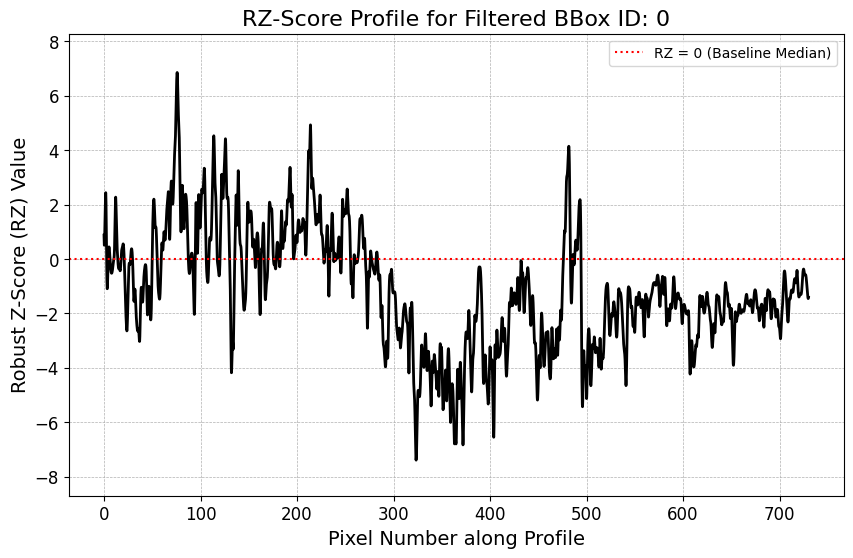

--- 正在处理第 2/4 个剖面线 ---


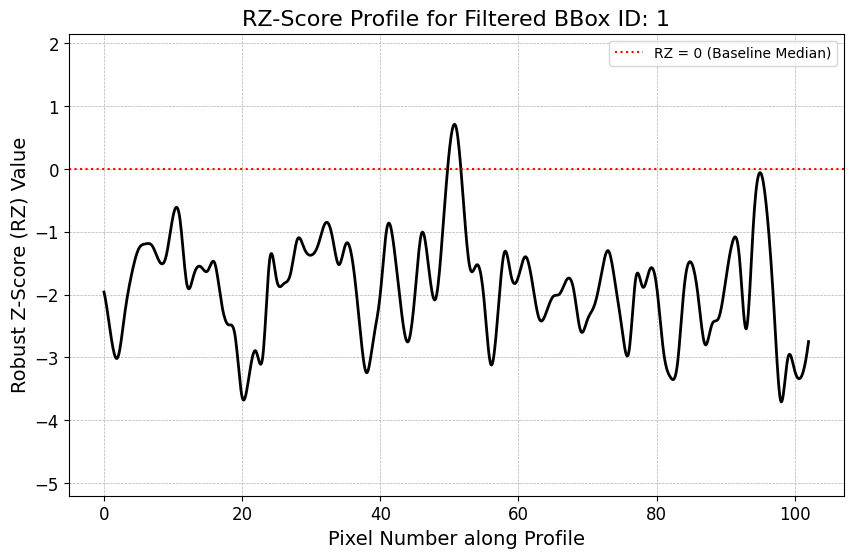

--- 正在处理第 3/4 个剖面线 ---


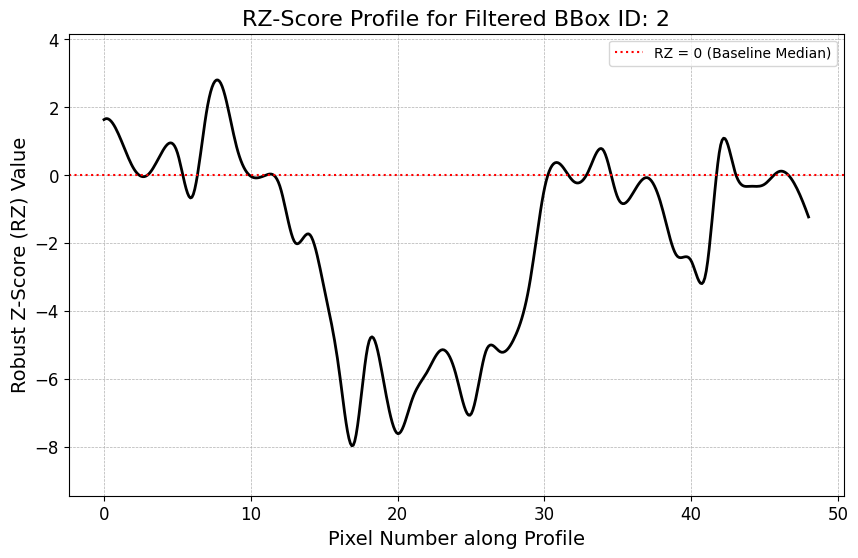

--- 正在处理第 4/4 个剖面线 ---


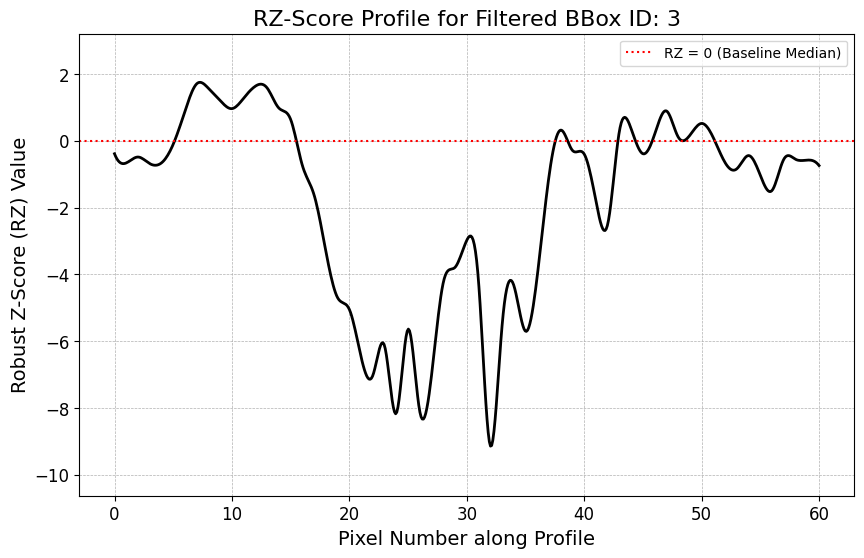

In [28]:
# 剖面线RZ-Score曲线可视化
import matplotlib.pyplot as plt
import numpy as np

# (新增) 导入样条插值函数，这是实现平滑的核心
from scipy.interpolate import make_interp_spline

print("\n--- [升级版] 开始为筛选通过的剖面线生成平滑的RZ-Score剖面图 ---")

# 检查 'filtered_boundingBoxes' 是否存在且包含要素
if 'filtered_boundingBoxes' in globals() and filtered_boundingBoxes.size().getInfo() > 0:
    
    valid_bboxes_list = filtered_boundingBoxes.toList(filtered_boundingBoxes.size())
    num_bboxes = valid_bboxes_list.size().getInfo()
    
    print(f"共找到 {num_bboxes} 个有效的剖面线，将逐一为其绘图。")

    # 遍历列表中的每一个要素 (Feature)
    for i in range(num_bboxes):
        print(f"--- 正在处理第 {i+1}/{num_bboxes} 个剖面线 ---")
        
        feature = ee.Feature(valid_bboxes_list.get(i))
        profile_line = ee.Geometry(feature.get('profile_line'))
        
        sampled_dict = rz_image.select('VV').reduceRegion(
            reducer=ee.Reducer.toList(),
            geometry=profile_line,
            scale=10,
            maxPixels=1024
        )
        
        rz_values = ee.List(sampled_dict.get('VV')).getInfo()
        
        # (修改) 至少需要4个点才能进行三次样条插值
        if not rz_values or len(rz_values) < 4:
            print(f"  > 警告：ID {i} 的剖面线采样点不足 (<4)，无法生成平滑曲线，跳过绘图。")
            continue

        # --- 开始使用 Matplotlib 绘图 ---
        
        plt.figure(figsize=(10, 6)) # 可以适当调整图像大小
        
        # --- (核心修改) 创建平滑曲线 ---
        # 1. 定义原始的X轴和Y轴数据
        x_original = np.array(range(len(rz_values)))
        y_original = np.array(rz_values)

        # 2. 创建一个更密集的X轴，用于绘制平滑曲线（例如，点数是原来的10倍）
        x_smooth = np.linspace(x_original.min(), x_original.max(), len(x_original) * 10)

        # 3. 创建样条插值函数 (k=3 表示三次样条，能保证曲线足够平滑)
        spline = make_interp_spline(x_original, y_original, k=3)
        
        # 4. 计算平滑曲线对应的Y轴值
        y_smooth = spline(x_smooth)
        # --- 平滑处理结束 ---

        # (核心修改) 绘制平滑曲线，去掉了 marker='.'
        plt.plot(x_smooth, y_smooth, linestyle='-', color='black', linewidth=2)
        
        # 图表元素保持不变，但可以调整字体大小使其更清晰
        plt.title(f'RZ-Score Profile for Filtered BBox ID: {i}', fontsize=16)
        plt.xlabel('Pixel Number along Profile', fontsize=14)
        plt.ylabel('Robust Z-Score (RZ) Value', fontsize=14)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        
        plt.axhline(0, color='red', linestyle=':', linewidth=1.5, label='RZ = 0 (Baseline Median)')
        plt.legend()
        
        # 调整Y轴范围，并增加一点边距
        plt.ylim(min(y_original) - 1.5, max(y_original) + 1.5)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)

        plt.show()

else:
    print("未找到任何通过筛选的剖面线 ('filtered_boundingBoxes')，无法绘制剖面图。")

# 8.监测洪水RZ阈值计算

## 1.np_gradient+可视化梯度最大值点+限制LINE上RZ+计算阈值

In [29]:
VALLEY_POINT_THRESHOLD = -1.0

# ==============================================================================
# 核心函数 (最终版 - 在V8基础上升级算法)
# ==============================================================================
def calculate_threshold_and_get_key_points(feature):
    """
    [最终版]
    - 保持了V8版本返回关键点几何体的结构。
    - 内部实现了“在暗区中寻找梯度极值”的最终高级算法。
    - 修复了多次 reduceRegion 的问题，提高了效率。
    """
    try:
        # --- 1. 数据准备 ---
        profile_line = ee.Geometry(feature.get('profile_line'))
        if profile_line is None:
            return feature.set({'local_threshold': -999, 'error_msg': 'Profile line is missing'})

        # [效率优化] 一次性获取 RZ-Score, 经度, 纬度
        lon_lat_image = ee.Image.pixelLonLat()
        rz_dict = rz_image.select('VV').reduceRegion(reducer=ee.Reducer.toList(), geometry=profile_line, scale=10)
        lon_dict = lon_lat_image.select('longitude').reduceRegion(reducer=ee.Reducer.toList(), geometry=profile_line, scale=10)
        lat_dict = lon_lat_image.select('latitude').reduceRegion(reducer=ee.Reducer.toList(), geometry=profile_line, scale=10)
        rz_values, longitudes, latitudes = ee.List(rz_dict.get('VV')).getInfo(), ee.List(lon_dict.get('longitude')).getInfo(), ee.List(lat_dict.get('latitude')).getInfo()
        if not rz_values or len(rz_values) < 3: return feature.set({'local_threshold': -999})


        # --- 2. 客户端最终高级梯度分析 ---
        rz_array = np.array(rz_values)
        gradients = np.gradient(rz_array)

        # a. 创建一个“谷点”数组
        valley_points = np.minimum(rz_array[:-1], rz_array[1:]) #比较rz除第一个元素以外的子数组和除最后一个元素以外的子数组（即rz[i]和rz[i+1] 以识别梯度低值<-2的点）

        # b. 找到所有“合格梯度”的索引
        qualified_indices = np.where(valley_points < VALLEY_POINT_THRESHOLD)[0]

        if len(qualified_indices) < 2:
            return feature.set({'local_threshold': -999, 'reason': f'Not enough qualified gradients (<2)'})

        # c. 只提取这些“合格”的梯度值
        qualified_gradients = gradients[qualified_indices]

        if len(qualified_gradients) == 0:
             return feature.set({'local_threshold': -999, 'reason': 'No qualified gradients found'})

        # d. 在“合格梯度”中寻找最大和最小值
        local_idx_max = np.argmax(qualified_gradients)
        local_idx_min = np.argmin(qualified_gradients)

        # e. 将局部索引映射回原始的全长数组索引
        original_idx_max_grad = qualified_indices[local_idx_max]
        original_idx_min_grad = qualified_indices[local_idx_min]

        # f. 提取最终锚点值（即谷点的值）
        rz_at_neg_grad_point = valley_points[original_idx_min_grad]
        rz_at_pos_grad_point = valley_points[original_idx_max_grad]
        rz_at_pos_gradfront_point = valley_points[original_idx_max_grad+1]

        # g. 计算最终阈值
        #local_threshold = (rz_at_neg_grad_point + rz_at_pos_grad_point) / 2.0
        local_threshold = (rz_at_pos_grad_point + rz_at_pos_gradfront_point) / 2.0

        # h. 获取关键点的坐标 (谷点所在的位置)
        neg_valley_idx = original_idx_min_grad if rz_array[original_idx_min_grad] < rz_array[original_idx_min_grad+1] else original_idx_min_grad + 1
        pos_valley_idx = original_idx_max_grad if rz_array[original_idx_max_grad] < rz_array[original_idx_max_grad+1] else original_idx_max_grad + 1

        neg_grad_point_geom = ee.Geometry.Point([longitudes[neg_valley_idx], latitudes[neg_valley_idx]])
        pos_grad_point_geom = ee.Geometry.Point([longitudes[pos_valley_idx], latitudes[pos_valley_idx]])

        # i. 准备返回结果
        return feature.set({
            'local_threshold': local_threshold,
            'neg_grad_point': neg_grad_point_geom,
            'pos_grad_point': pos_grad_point_geom
        })

    except Exception as e:
        return feature.set({'local_threshold': -999, 'error_msg': str(e)})


# 主循环与数据处理 (包含了打印阈值的功能)
# ==============================================================================
if 'filtered_boundingBoxes' not in globals() or filtered_boundingBoxes.size().getInfo() == 0:
    print("错误：未找到名为 'filtered_boundingBoxes' 的有效FeatureCollection。")
    print("请确保您已成功运行了之前的筛选步骤。")
else:
    print(f"\n--- [V12 最终完整版] 开始为 {filtered_boundingBoxes.size().getInfo()} 个已筛选的矩形计算局部阈值 ---")
    print("="*100)
    print(f"{'Rect ID':<15} | {'Threshold':<15} | {'Status':<15} | {'Reason/Details'}")
    print("-"*100)

    neg_grad_coords_list = []
    pos_grad_coords_list = []
    final_features_with_thresholds_list = []

    valid_bboxes_list = filtered_boundingBoxes.toList(filtered_boundingBoxes.size())
    for i in range(valid_bboxes_list.size().getInfo()):
        valid_feature = ee.Feature(valid_bboxes_list.get(i))
        feature_with_results = calculate_threshold_and_get_key_points(valid_feature)

        properties = feature_with_results.getInfo()['properties']
        local_threshold = properties.get('local_threshold', -999)
        reason = properties.get('reason', 'N/A')
        status = "SUCCESS" if local_threshold != -999 else "FAILED"
        threshold_str = f"{local_threshold:.2f}" if status == "SUCCESS" else "N/A"
        original_id = properties.get('label', i) # 假设原始矩形有label属性，没有则用索引

        print(f"{original_id:<15} | {threshold_str:<15} | {status:<15} | {reason}")

        if status == "SUCCESS":
            final_features_with_thresholds_list.append(feature_with_results)
            neg_point_coords = properties.get('neg_grad_point', {}).get('coordinates')
            pos_point_coords = properties.get('pos_grad_point', {}).get('coordinates')
            if neg_point_coords: neg_grad_coords_list.append(neg_point_coords)
            if pos_point_coords: pos_grad_coords_list.append(pos_point_coords)

    print("="*100)

    # ==============================================================================
    # 可视化模块
    # ==============================================================================
    print("\n--- [V12 最终完整版] 可视化模块 ---")

    # 可视化所有最初通过筛选的矩形（灰色，作为底图）
    #Map.addLayer(ee.Image().byte().paint(filtered_boundingBoxes, 0, 1), {'palette': '808080'}, 'Initial Filtered BBoxes (Gray)')

    if final_features_with_thresholds_list:
        # 将成功计算出阈值的要素转为 FeatureCollection
        valid_bboxes_with_thresh = ee.FeatureCollection(final_features_with_thresholds_list)
        Map.addLayer(ee.Image().byte().paint(valid_bboxes_with_thresh, 0, 2), {'palette': '00FF00'}, 'BBoxes with Final Threshold (Green)')

        # 在客户端重建干净的 FeatureCollection 用于可视化梯度点
        neg_points_features = [ee.Feature(ee.Geometry.Point(coords)) for coords in neg_grad_coords_list]
        pos_points_features = [ee.Feature(ee.Geometry.Point(coords)) for coords in pos_grad_coords_list]
        neg_points_fc = ee.FeatureCollection(neg_points_features)
        pos_points_fc = ee.FeatureCollection(pos_points_features)

        # 添加关键梯度点到地图
        Map.addLayer(neg_points_fc, {'color': 'FF0000', 'pointSize': 5}, 'Max Negative Gradient Points (Red)')
        Map.addLayer(pos_points_fc, {'color': '0000FF', 'pointSize': 5}, 'Max Positive Gradient Points (Blue)')

        print(f"\n成功为 {len(final_features_with_thresholds_list)} 个矩形计算出阈值并已可视化。")
        try:
            Map.centerObject(neg_points_fc.first(), 14)
        except:
            # 如果没有点，安全退出
            pass
    else:
        print("\n没有成功计算出任何局部阈值。")

    # 确保地图对象被显示
Map


--- [V12 最终完整版] 开始为 4 个已筛选的矩形计算局部阈值 ---
Rect ID         | Threshold       | Status          | Reason/Details
----------------------------------------------------------------------------------------------------
0               | -1.91           | SUCCESS         | Passed
1               | -0.37           | SUCCESS         | Passed
2               | -1.81           | SUCCESS         | Passed
3               | -5.63           | SUCCESS         | Passed

--- [V12 最终完整版] 可视化模块 ---

成功为 4 个矩形计算出阈值并已可视化。


Map(bottom=199916.0, center=[39.387487031740335, -0.36017951316772207], controls=(WidgetControl(options=['posi…

# 2.EMWA梯度法

In [30]:
def calculate_threshold_by_ewma(feature):
    try:
        # --- 1.数据准备 ---
        profile_line = ee.Geometry(feature.get('profile_line'))
        if profile_line is None:
            return feature.set({'local_threshold': -999, 'error_msg': 'Profile line is missing'})
        
        lon_lat_image = ee.Image.pixelLonLat() #生成双波段（经纬度）图像
        
        #提取线上RZ，lon,lat值并提取到客户端信息
        rz_dict = rz_image.select('VV').reduceRegion(
            reducer = ee.Reducer.toList(),
            geometry = profile_line,
            scale = 10
            )
        lon_dict = lon_lat_image.select('longitude').reduceRegion(
            reducer = ee.Reducer.toList(),
            geometry = profile_line,
            scale = 10
        )
        lat_dict = lon_lat_image.select('latitude').reduceRegion(
            reducer=ee.Reducer.toList(), 
            geometry=profile_line, 
            scale=10
        )
        
        rz_values,longitudes,latitudes = ee.List(rz_dict.get('VV')).getInfo(),ee.List(lon_dict.get('longitude')).getInfo(),ee.List(lat_dict.get('latitude')).getInfo()
        
        # --- 2.1 核心算法： 双向EWMA梯度计算——左右坡度相乘法 ---
        rz_array = np.array(rz_values)
        n = len(rz_array)
        if n < 3: #至少需要三个点
            return feature.set({'local_threshold': -999, 'reason': 'Not enough points on profile (<3)'})
        
        # a.左向右传递(Left Pass)
        g_left = np.zeros(n)
        m_left = np.zeros(n) #左侧的加权记忆
        m_left[0] = rz_array[0] # 在起点时，全部记忆就是脚下的值
        for k in range(i,n):
            m_left[k] = (m_left[k-1] + rz_array[k]) / 2.0 #更新记忆
            g_left[k] = abs(rz_array[k] - m_left[k-1]) #计算左侧坡度
            
        # b.右向左传递(Right Pass)
        g_right = np.zeros(n)
        m_right = np.zeros(n)
        m_right[n-1] = rz_array[n-1] # 从末端初始化
        for k in range(n - 2, -1, -1): # 从倒数第二个倒着循环
            m_right[k] = (m_right[k+1] + rz_array[k]) / 2.0
            g_right[k] = abs(rz_array[k] - m_right[k+1])
        
        # c.寻找相遇点（左右梯度乘积最大值）
        g_product = g_left * g_right
        
        # 为避免边界效应 在内部寻找最大值
        if n > 4:
            boundary_index = np.argmax(g_product[1:-1]) + 1 #排除数组首尾元素 找到的元素索引加1
        else:
            boundary_index = np.argmax(g_product)
        
        # d.计算最终阈值
        if boundary_index + 1 >= n:
             return feature.set({'local_threshold': -999, 'reason': 'Boundary found at edge'})
        local_threshold = (rz_array[boundary_index] + rz_array[boundary_index + 1]) / 2.0
        
        # e.获取并定义可视化的两个关键边界点
        # 这两个点共同定义了最终的阈值
        boundary_point_1_geom = ee.Geometry.Point([longitudes[boundary_index],latitudes[boundary_index]])
        boundary_point_2_geom = ee.Geometry.Point([longitudes[boundary_index + 1],latitudes[boundary_index + 1]])
        
         # f. 准备返回结果
        return feature.set({
            'local_threshold': local_threshold,
            'boundary_point_1': boundary_point_1_geom,
            'boundary_point_2': boundary_point_2_geom,
            'reason': f'Success. Boundary at index {boundary_index}'
        })

        
        
        
    except Exception as e:
        return feature.set({'local_threshold': -999, 'error_msg': str(e)})
    
# 主循环与数据处理 (已更新以调用新函数并适配其输出)
# ==============================================================================
if 'filtered_boundingBoxes' not in globals() or filtered_boundingBoxes.size().getInfo() == 0:
    print("错误：未找到名为 'filtered_boundingBoxes' 的有效FeatureCollection。")
    print("请确保您已成功运行了之前的筛选步骤。")
else:
    print(f"\n--- [新版 EWMA梯度法] 开始为 {filtered_boundingBoxes.size().getInfo()} 个已筛选的矩形计算局部阈值 ---")
    print("="*100)
    print(f"{'Rect ID':<15} | {'Threshold':<15} | {'Status':<15} | {'Reason/Details'}")
    print("-"*100)

    # 用于存储可视化点的坐标列表
    key_point_1_coords_list = []
    key_point_2_coords_list = []
    final_features_with_thresholds_list = []

    valid_bboxes_list = filtered_boundingBoxes.toList(filtered_boundingBoxes.size())
    for i in range(valid_bboxes_list.size().getInfo()):
        valid_feature = ee.Feature(valid_bboxes_list.get(i))
        # !!! 调用新的核心函数 !!!
        feature_with_results = calculate_threshold_by_ewma(valid_feature)

        properties = feature_with_results.getInfo()['properties']
        local_threshold = properties.get('local_threshold', -999)
        reason = properties.get('reason', 'N/A')
        status = "SUCCESS" if local_threshold != -999 else "FAILED"
        threshold_str = f"{local_threshold:.2f}" if status == "SUCCESS" else "N/A"
        original_id = properties.get('label', i)

        print(f"{original_id:<15} | {threshold_str:<15} | {status:<15} | {reason}")

        if status == "SUCCESS":
            final_features_with_thresholds_list.append(feature_with_results)
            # !!! 获取新的关键点坐标 !!!
            point_1_coords = properties.get('boundary_point_1', {}).get('coordinates')
            point_2_coords = properties.get('boundary_point_2', {}).get('coordinates')
            if point_1_coords: key_point_1_coords_list.append(point_1_coords)
            if point_2_coords: key_point_2_coords_list.append(point_2_coords)

    print("="*100)

    # ==============================================================================
    # 可视化模块 (已更新以显示新的关键点)
    # ==============================================================================
    print("\n--- [新版 EWMA梯度法] 可视化模块 ---")

    if final_features_with_thresholds_list:
        valid_bboxes_with_thresh = ee.FeatureCollection(final_features_with_thresholds_list)
        #Map.addLayer(ee.Image().byte().paint(valid_bboxes_with_thresh, 0, 2), {'palette': '00FF00'}, 'BBoxes with Final Threshold (Green)')

        # !!! 重建并可视化新的边界点 !!!
        point_1_features = [ee.Feature(ee.Geometry.Point(coords)) for coords in key_point_1_coords_list]
        point_2_features = [ee.Feature(ee.Geometry.Point(coords)) for coords in key_point_2_coords_list]
        point_1_fc = ee.FeatureCollection(point_1_features)
        point_2_fc = ee.FeatureCollection(point_2_features)

        # 添加新的关键边界点到地图
        Map.addLayer(point_1_fc, { 'color':'FFA500', 'pointSize': 5}, 'multiple  Points 1 (Orange)')
        #Map.addLayer(point_2_fc, {'color': '3300CC', 'pointSize': 5}, 'multiple Points 2 (Blue)')

        print(f"\n成功为 {len(final_features_with_thresholds_list)} 个矩形计算出阈值并已可视化。")
        try:
            Map.centerObject(point_1_fc.first(), 14)
        except:
            pass
    else:
        print("\n没有成功计算出任何局部阈值。")
Map










--- [新版 EWMA梯度法] 开始为 4 个已筛选的矩形计算局部阈值 ---
Rect ID         | Threshold       | Status          | Reason/Details
----------------------------------------------------------------------------------------------------
0               | -3.61           | SUCCESS         | Success. Boundary at index 132
1               | -0.39           | SUCCESS         | Success. Boundary at index 95
2               | -6.47           | SUCCESS         | Success. Boundary at index 17
3               | -7.35           | SUCCESS         | Success. Boundary at index 32

--- [新版 EWMA梯度法] 可视化模块 ---

成功为 4 个矩形计算出阈值并已可视化。


Map(bottom=798798.0, center=[39.38748703174034, -0.3928781895096728], controls=(WidgetControl(options=['positi…

# 9.结合局部最优和全局最优的洪水提取

In [ ]:
# ==============================================================================
# 第9步: 最终洪水淹没范围提取 (局部阈值 + 全局平均阈值)
# ==============================================================================

print("\n--- [第9步] 开始最终的洪水淹没范围提取 ---")

#--- 1. 数据准备 ---
if 'final_features_with_thresholds_list' not in globals() or not final_features_with_thresholds_list:
    print("错误：未找到包含有效局部阈值的要素列表。无法进行最终分析。")
else:
    # 将Python列表转回为GEE-Featurecollection
    final_results_fc = ee.FeatureCollection(final_features_with_thresholds_list)
    
    #提取所有的局部阈值，准备计算平均值
    local_threshold_list = final_results_fc.aggregate_array('local_threshold')
    
    # -- 2.计算全局平均阈值 ---
    # 在客户端计算所有有效局部阈值的平均值
    # 我们需要先通过.getInfo()获取列表
    local_thresholds_py_list = local_threshold_list.getInfo()
    if local_thresholds_py_list:
        global_average_threshold = np.mean(local_thresholds_py_list) #用np.mean()算平均
        print(f"共计算了 {len(local_thresholds_py_list)} 个局部阈值。")
        print(f"计算出的全局平均阈值为: {global_average_threshold:.2f}")
    else:
        # 如果没有任何矩形成功，使用一个备用阈值
        global_average_threshold = -2.5
        print("警告：没有任何有效的局部阈值，将使用备用全局阈值: -2.5")
    
    # --- 3.对每个矩形内部应用其局部阈值 ---
    # 使用.map()来遍历每一个带有阈值的矩形
    def apply_local_threshold(feature):
        #从要素属性中获取这个矩形专属的局部阈值
        local_thresh = ee.Number(feature.get('local_threshold'))
        # 找到RZ影像中低于该局部阈值的像素，并限定在该矩形内
        local_flood_mask = rz_image.lt(local_thresh).And(ee.Image.constant(1).clip(feature.geometry()))
        return local_flood_mask.selfMask()
    
    # 对集合中的所有要素应用上述函数，得到一个局部洪水的影像集合
    list_of_local_flood_images = final_results_fc.map(apply_local_threshold)
    
    # 将所有局部的洪水影像合并成一张影像
    # 影像集合的.mosaic() 会将所有影像叠加一起 
    all_local_floods = ee.ImageCollection(list_of_local_flood_images).mosaic()
    
    # --- 4.对所有矩形外部区域应用全局平均阈值 ---
    
    # 首先，创建一个能代表所有矩形合并区域的影像
    all_bboxes_mask = final_results_fc.style(**{'fillColor': 'black'}).Not().select(0) #rgb图像选取一个波段
    
    # 在RZ影像中，。找到所有低于全局平均阈值的像素
    potential_global_flood = rz_image.lt(global_average_threshold)
    
    # --- 5. 合并局部和全局洪水图，得到最终结果 ---
    
   # a. 将局部洪水图中被掩膜的区域（即矩形外）用0填充，并移除其限制性掩膜
    #    这样 all_local_floods_unmasked 在整个研究区都变得不透明了
    all_local_floods_unmasked = all_local_floods.unmask(0)

    # b. 将全局洪水图中，位于矩形内部的部分挖掉 (设为0)
    #    这个逻辑保持不变
    intra_region_mask = all_local_floods.mask().Not().Not()
    extra_regional_flood_only = potential_global_flood.where(intra_region_mask, 0)

    # c. 将两个在整个研究区都有效的影像相加
    #    现在因为两张图的掩膜都是覆盖整个研究区的，所以不会再有掩膜传播问题
    final_flood_map = extra_regional_flood_only.add(all_local_floods_unmasked)

    
    # --- 6. 可视化最终成果 ---
    
    print("\n--- 可视化最终洪水淹没图 ---")
    
    flood_palette = ['#0000FF'] # 用蓝色代表洪水
    Map.addLayer(final_flood_map.selfMask(), {'palette': '#0000FF'}, 'Final Flood Extent (Hybrid Threshold)')
    
    # 将地图重新居中到研究区
    Map.centerObject(roi_choose1, 11)
    
    # 确保地图被显示
Map
    
    
        
        
        
    

# 10.计算一个月洪水持续天数

In [ ]:
# ==============================================================================
# 新模块: (修正版) 计算 2024-10-25 到 2024-12-01 每个像素的洪水持续天数
# ==============================================================================

print("\n--- [新模块] 开始计算洪水持续天数 ---")

# --- 1. 定义日期范围 ---
flood_start_date = '2024-10-25'
flood_end_date = '2024-12-01'

# --- 2. 过滤洪水期的影像集合 ---
# 注意：这里我们只筛选洪水期的影像，基线期影像将在后面单独处理
s1_flood_series = ee.ImageCollection("COPERNICUS/S1_GRD") \
    .filterBounds(roi_choose1) \
    .filterDate(flood_start_date, flood_end_date) \
    .filter(ee.Filter.equals("instrumentMode", "IW")) \
    .filter(ee.Filter.listContains("transmitterReceiverPolarisation", "VV")) \
    .filter(ee.Filter.equals("orbitProperties_pass", "ASCENDING"))

series_size = s1_flood_series.size().getInfo()
print(f"在 {flood_start_date} 到 {flood_end_date} 期间找到 {series_size} 景 Sentinel-1 影像。")

if series_size == 0:
    print("警告：洪水期内未找到影像，无法计算持续天数。")
else:
    # --- 3. (核心修正) 在循环外预先计算基线期的统计值 ---
    # 我们需要一个包含基线期所有影像的集合
    s1_baseline_collection = ee.ImageCollection("COPERNICUS/S1_GRD") \
        .filterBounds(roi_choose1) \
        .filterDate(basestart, baseend) \
        .filter(ee.Filter.equals("instrumentMode", "IW")) \
        .filter(ee.Filter.listContains("transmitterReceiverPolarisation", "VV")) \
        .filter(ee.Filter.equals("orbitProperties_pass", "ASCENDING"))

    print("正在预计算基线期的中值和MAD...")
    # 直接调用您的函数来计算一次性的基线中值和MAD
    baseline_median_image = calc_basemedian(s1_baseline_collection, basestart, baseend, 'IW', 'ASCENDING')
    baseline_mad_image = calc_basemad(s1_baseline_collection, basestart, baseend, 'IW', 'ASCENDING')
    print("基线统计值计算完成。")

    # --- 4. map 函数：对每个影像计算洪水掩膜 ---
    def detect_flood_per_image(image):
        # (核心修正) 直接使用预计算好的基线统计值来计算RZ-score
        # RZ = (Current - Median) / MAD
        rz_per_image = image.subtract(baseline_median_image).divide(baseline_mad_image)
        
        # 应用阈值：RZ < -2 为洪水 (假设RZ-score的波段名继承自原始影像, 如'VV')
        # 我们需要确保rz_per_image有名为'VV'的波段
        flood_mask = rz_per_image.select('VV').lt(-2)
        
        # 开运算：腐蚀后膨胀以去除噪声
        kernel = ee.Kernel.circle(radius=2)
        opened_mask = flood_mask.focal_min(kernel=kernel, iterations=1) \
                                .focal_max(kernel=kernel, iterations=1)
        
        # 必须返回一个带有时间戳的影像
        return opened_mask.set('system:time_start', image.get('system:time_start'))

    flood_mask_series = s1_flood_series.map(detect_flood_per_image)

    # --- 5. 计算每个像素的洪水持续天数 (这部分逻辑是正确的，无需修改) ---
    def timestamp_mask(image):
        time = ee.Image.constant(image.get('system:time_start')).toLong().rename('time')
        # updateMask只在image像素值为1（洪水）的地方保留时间戳
        return time.updateMask(image)

    timestamp_series = flood_mask_series.map(timestamp_mask)

    first_flood_time = timestamp_series.min().rename('first_time')
    last_flood_time = timestamp_series.max().rename('last_time')

    duration_ms = last_flood_time.subtract(first_flood_time)
    # 加上一个很小的时间（例如半个重访周期），确保首次发现洪水也算持续时间
    # Sentinel-1 重访周期约6天，这里加3天
    duration_days = duration_ms.add(1000 * 3600 * 24 * 3).divide(1000 * 3600 * 24).int().rename('flood_duration_days')
    
    duration_days = duration_days.updateMask(duration_days.gt(0))

    # --- 6. 可视化 ---
    duration_palette = ['#FFFF00', '#FFA500', '#FF0000', '#8B0000']  # 黄 -> 橙 -> 红 -> 深红
    Map.addLayer(duration_days, {'min': 1, 'max': 30, 'palette': duration_palette}, 'Flood Duration (Days)')
    Map.centerObject(roi_choose1, 10)

Map  # 显示更新后的地图

# 11.导出数据

In [ ]:
import os

print("\n--- [第10步] 开始准备导出所有分析结果 ---")

# --- 1. 定义通用导出参数 ---

# 定义一个统一的研究区边界，所有导出都将基于这个范围
# .geometry()确保我们传递的是纯几何对象，而不是带有属性的Feature
export_region = roi_choose1

# 定义影像的导出分辨率（米），10米是Sentinel-1的标称分辨率
export_scale = 10 

# --- 2. 准备需要导出的图层 ---
# GEE的paint()方法生成的图层需要重新构建才能导出
# 我们需要将FeatureCollection“烧录”到一张空的影像上

# a. 筛选后的外包矩形轮廓影像
if 'filtered_boundingBoxes' in globals() and filtered_boundingBoxes.size().getInfo() > 0:
    filtered_outline_image = ee.Image().byte().paint(
        featureCollection=filtered_boundingBoxes, 
        color=1, 
        width=2
    )
else:
    print("警告：'filtered_boundingBoxes' 不存在或为空，将导出一张空图。")
    filtered_outline_image = ee.Image(0).rename('outline')


# b. 有效的剖面线影像
if 'filtered_boundingBoxes' in globals() and filtered_boundingBoxes.size().getInfo() > 0:
    # 确保之前的'extract_profile_as_feature'函数可用
    valid_profile_lines_fc = filtered_boundingBoxes.map(extract_profile_as_feature)
    valid_profile_lines_image = ee.Image().byte().paint(
        featureCollection=valid_profile_lines_fc,
        color=1,
        width=2
    )
else:
    print("警告：无法生成'valid_profile_lines_image'，将导出一张空图。")
    valid_profile_lines_image = ee.Image(0).rename('profile_lines')


# --- 3. 选择您的导出方法 (请取消注释您想使用的方法) ---

################################################################################
# 方法一：导出到 GOOGLE DRIVE (推荐，更稳定)
################################################################################

# 在你的Google Drive中创建一个文件夹来存放所有结果, 文件夹名以目标日期命名
gdrive_folder = f"valencia_GEE_Flood_Analysis_{targdate}"

print(f"\n--- 方法一：正在提交导出任务到 Google Drive ---")
print(f"所有文件将被保存在Google Drive的 '{gdrive_folder}' 文件夹中。")
print("请稍后前往GEE Code Editor的 'Tasks' 标签页手动运行任务。")

# A. 导出栅格影像 (Images)
# 使用字典来管理所有待导出的影像，清晰明了
image_exports_gdrive = {
    "01_SAR_Target_Date": sar_image,
    "02_SAR_Baseline_Median": baseline_median,
    "03_MAD": clipped_MAD,
    "04_RZ_Score": rz_image,
    "05_OTSU_Initial_Water": globalWater,
    "06_OTSU_Eroded": eroded_Dark_tagerts,
    "07_Edge_Buffer": bufferedEdges,
    "08_Filtered_BBoxes_Outline": filtered_outline_image,
    "09_Valid_Profile_Lines": valid_profile_lines_image,
    "11_Final_Flood_Map": final_flood_map.toByte() # 转为Byte节省空间
}

for name, image in image_exports_gdrive.items():
    task = ee.batch.Export.image.toDrive(
        image=image.clip(export_region), # 确保只导出ROI内部
        description=f'Export_{name}',
        folder=gdrive_folder,
        fileNamePrefix=name,
        region=export_region,
        scale=export_scale,
        fileFormat='GeoTIFF',
        maxPixels=1e13
    )
    task.start()
    print(f"  > 已提交影像 '{name}' 的导出任务。")

# B. 导出矢量数据 (FeatureCollections)
# 确保梯度点FeatureCollection存在且不为空
vector_exports_gdrive = {}
if 'neg_points_fc' in globals() and neg_points_fc.size().getInfo() > 0:
    vector_exports_gdrive["10a_Negative_Gradient_Points"] = neg_points_fc
if 'pos_points_fc' in globals() and pos_points_fc.size().getInfo() > 0:
    vector_exports_gdrive["10b_Positive_Gradient_Points"] = pos_points_fc

if vector_exports_gdrive:
    for name, collection in vector_exports_gdrive.items():
        task = ee.batch.Export.table.toDrive(
            collection=collection,
            description=f'Export_{name}',
            folder=gdrive_folder,
            fileNamePrefix=name,
            fileFormat='SHP' # 可选 'GeoJSON', 'KML'
        )
        task.start()
        print(f"  > 已提交矢量 '{name}' 的导出任务。")
else:
    print("  > 未找到有效的梯度点数据，跳过矢量导出。")